In [ ]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import random
import cv2
import os #to join the data directory with the file
import ntpath #to edit the path name in the image dataset

from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten #dropout sets to 0
from keras.layers.convolutional import Convolution2D, MaxPooling2D #CNN
from sklearn.model_selection import train_test_split

In [ ]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [ ]:
#removes the path name from the image columns 

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


total data: 4053
removed: 2590
remaining: 1463


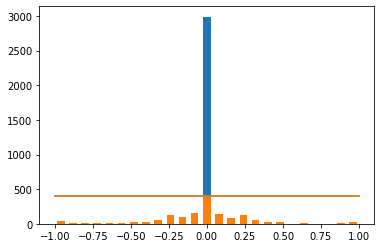

In [ ]:
#Descriptive analysis for the steering variable

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))


remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

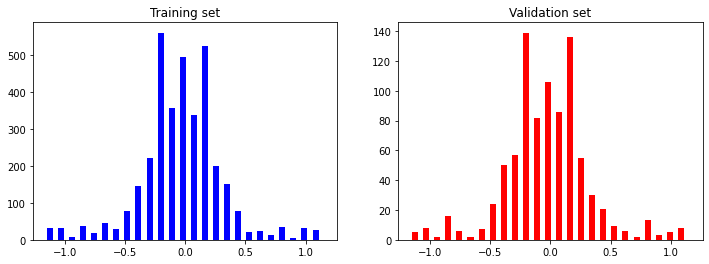

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  return img

Text(0.5, 1.0, 'preprocessed set')

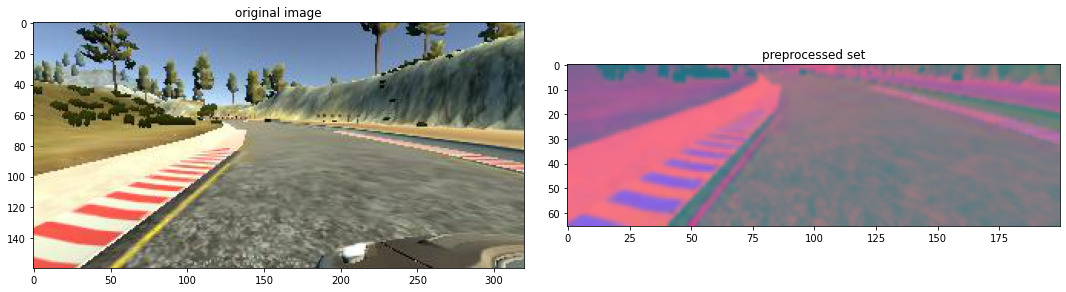

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('preprocessed set')

In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

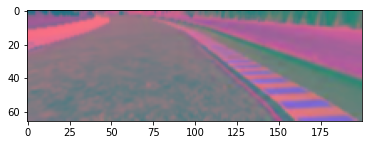

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
  

In [ ]:
import tensorflow as tf
from tensorflow import keras

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer, metrics = ['accuracy'])
  return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

Epoch 1/30
36/36 [==============================] - 24s 655ms/step - loss: 3.3604 - accuracy: 0.0680 - val_loss: 0.1852 - val_accuracy: 0.0900
Epoch 2/30
36/36 [==============================] - 23s 651ms/step - loss: 0.1662 - accuracy: 0.0962 - val_loss: 0.1147 - val_accuracy: 0.0968
Epoch 3/30
36/36 [==============================] - 23s 651ms/step - loss: 0.1068 - accuracy: 0.1035 - val_loss: 0.0961 - val_accuracy: 0.0968
Epoch 4/30
36/36 [==============================] - 23s 651ms/step - loss: 0.0961 - accuracy: 0.1118 - val_loss: 0.0897 - val_accuracy: 0.0968
Epoch 5/30
36/36 [==============================] - 23s 651ms/step - loss: 0.0926 - accuracy: 0.1052 - val_loss: 0.0853 - val_accuracy: 0.0979
Epoch 6/30
36/36 [==============================] - 23s 650ms/step - loss: 0.0791 - accuracy: 0.1099 - val_loss: 0.0798 - val_accuracy: 0.0968
Epoch 7/30
36/36 [==============================] - 23s 650ms/step - loss: 0.0740 - accuracy: 0.1144 - val_loss: 0.0813 - val_accuracy: 0.0968

Text(0.5, 0, 'epoch')

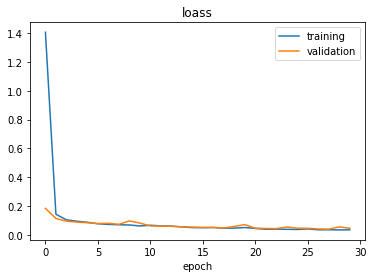

In [ ]:
history = model.fit(X_train, y_train, epochs = 30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)#plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loass')
plt.xlabel('epoch')
#loss is high 